**Unit test**

In [4]:
import sys
sys.path.append('./../py_programs/')
from Simulator import *
import tensorflow as tf
%pylab inline
from MakeModel import *

Populating the interactive namespace from numpy and matplotlib


# Test on  `Simulator.py`

In [2]:
# Disable all GPUs
try:
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    pass

# Set the number of threads
intra = 2  # threads used within an individual op for parallelism
inter = 2  # threads used for parallelism between independent operations
tf.config.threading.set_intra_op_parallelism_threads(intra)
tf.config.threading.set_inter_op_parallelism_threads(inter)

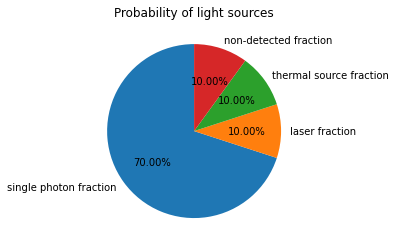

In [3]:
# test the simulator and piechart
s = Simulator.simulator(Nbins=200,  Ndet=1e5, nset=10, sps=0.7, laser=0.1, non=0.1, ther=0.1)

# get a pie chart for light sources
s.piechart()

In [4]:
# test the distribution function
s.total_dist

<tfp.distributions.Mixture 'Mixture' batch_shape=[] event_shape=[] dtype=float32>

Following plots are from the last set of data.


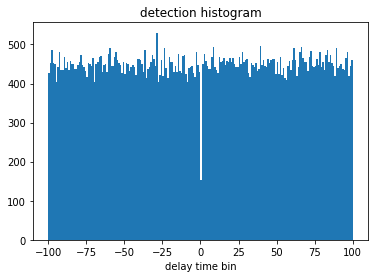

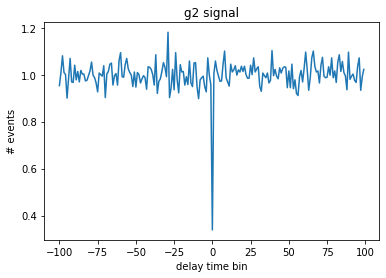

In [6]:
# test the get_data function and saved data files

data = s.get_data(plot=True, save=True, name='test')

Check the `test.txt` file in the `data` folder, the simulator seems to work.

In [8]:
# check the data file
data = Simulator.load_data('test.csv')
#print('it is a single photon source:' ,

In [9]:
data.shape

(10, 3, 200)

In [10]:
# get the result
Simulator.get_truth(data, thr = 0.5)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

*This means all of input data sets are sps*
Now let's try not sps case.

In [14]:
s2 = Simulator.simulator(Nbins=200,  Ndet=1e5, nset=10, sps=0.1, laser=0.2, non=0.2, ther=0.5)
s2data = s2.get_data()
Simulator.get_truth(data=s2data,thr=0.5)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# Test the Model

In [5]:
# load the data from files
filenames = []
x_ = []
y_ = []

# iterate over all files
#filenames = ['./../simulation/data/laser'] + ['./../simulation/data/sps']
filenames = ['./../simulation/data/halfhalf_rand/'+str(i) for i in range(10)]


for filename in filenames: 
    data = load_data(filename=filename)
    x_.append(data)
    
x_ = np.array(x_)
# convert data into correct shape
x_ = x_.reshape(x_.shape[0]*x_.shape[1],x_.shape[2],x_.shape[3])

# get the ground truth
threshold = 0.5
y_ = get_truth(x_, thr=threshold)

# we only need the g2signal for training
x_ = x_[:,2,:]
# shuffle
i = np.random.permutation(len(x_))
x_ = x_[i]
y_ = y_[i]

# reshape
x_ = x_.reshape(x_.shape[0], x_.shape[1], 1)
y_ = y_.reshape(y_.shape[0])

# allocate
x_train = x_[100:]
y_train = y_[100:]
x_test = x_[:100]
y_test = y_[:100]

In [16]:
model = make_model(x_train.shape[1:])


In [21]:
model_compile(model)

<bound method Model.compile of <tensorflow.python.keras.engine.functional.Functional object at 0x7fa7fc200d00>>

In [23]:
model_train(model, x_train, y_train, 5, 5, set_callback(save=True, name='./unittest'))


Epoch 1/5
126/126 [==============================] - 0s 2ms/step - loss: 0.1743 - sparse_categorical_accuracy: 0.3644 - binary_accuracy: 0.7190 - val_loss: 0.1902 - val_sparse_categorical_accuracy: 0.3741 - val_binary_accuracy: 0.7074
Epoch 2/5
126/126 [==============================] - 0s 675us/step - loss: 0.0925 - sparse_categorical_accuracy: 0.3976 - binary_accuracy: 0.9247 - val_loss: 0.0619 - val_sparse_categorical_accuracy: 0.3741 - val_binary_accuracy: 0.9556
Epoch 3/5
126/126 [==============================] - 0s 695us/step - loss: 0.0600 - sparse_categorical_accuracy: 0.3979 - binary_accuracy: 0.9350 - val_loss: 0.0432 - val_sparse_categorical_accuracy: 0.3741 - val_binary_accuracy: 0.9556
Epoch 4/5
126/126 [==============================] - 0s 674us/step - loss: 0.0547 - sparse_categorical_accuracy: 0.3771 - binary_accuracy: 0.9289 - val_loss: 0.0441 - val_sparse_categorical_accuracy: 0.3741 - val_binary_accuracy: 0.9556
Epoch 5/5
126/126 [==============================] - 0

In [25]:
info , activations = visualize_layer(model, x_train)

In [27]:
info

[('input_1', '->', (900, 200, 1), '- Numpy array'),
 ('lambda', '->', (900, 200, 1), '- Numpy array'),
 ('max_pooling1d', '->', (900, 40, 1), '- Numpy array'),
 ('lambda_1', '->', (900, 40, 1), '- Numpy array'),
 ('conv1d', '->', (900, 40, 4), '- Numpy array'),
 ('batch_normalization', '->', (900, 40, 4), '- Numpy array'),
 ('re_lu', '->', (900, 40, 4), '- Numpy array'),
 ('max_pooling1d_1', '->', (900, 8, 4), '- Numpy array'),
 ('flatten', '->', (900, 32), '- Numpy array'),
 ('dense', '->', (900, 10), '- Numpy array'),
 ('dense_1', '->', (900, 1), '- Numpy array')]

Text(0.5, 1.0, 'input layer')

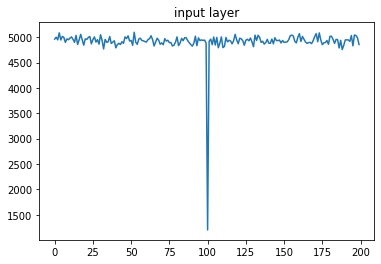

In [35]:
plt.plot(activations[list(activations.keys())[0]][1,:,0])
plt.title('input layer')

Text(0.5, 1.0, 'labmda_1 layer')

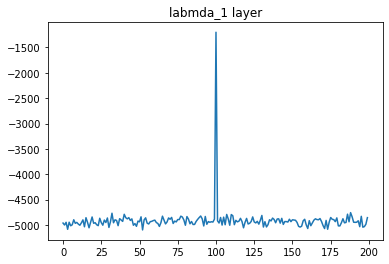

In [36]:
plt.plot(activations[list(activations.keys())[1]][1,:,0])
plt.title('labmda_1 layer')

Text(0.5, 1.0, 'output layer, with all data sets')

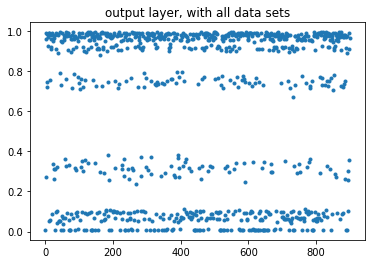

In [41]:
plt.plot(activations[list(activations.keys())[-1]][:,:],'.')
plt.title('output layer, with all data sets')